[INFO] loading images...
[INFO] encoding labels...


C:\Users\DELL\AppData\Local\Temp\ipykernel_11168\3710273726.py:66: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights="imagenet", include_top=False,


[INFO] compiling model...
[INFO] training head...
Epoch 1/20


C:\Users\DELL\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.5045 - loss: 0.9416 - val_accuracy: 0.6897 - val_loss: 0.6098
Epoch 2/20
 1/57 ━━━━━━━━━━━━━━━━━━━━ 38s 685ms/step - accuracy: 0.6250 - loss: 0.7364

C:\ProgramData\anaconda3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6250 - loss: 0.7364 - val_accuracy: 0.7143 - val_loss: 0.5656
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6651 - loss: 0.6508 - val_accuracy: 0.7388 - val_loss: 0.5469
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5000 - loss: 0.7298 - val_accuracy: 0.7857 - val_loss: 0.4660
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.6672 - loss: 0.6152 - val_accuracy: 0.7612 - val_loss: 0.5202
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5238 - loss: 0.8226 - val_accuracy: 0.8571 - val_loss: 0.4502
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7194 - loss: 0.5656 - val_accuracy: 0.7522 - val_loss: 0.5103
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7500 - loss: 0.5516 - val_accuracy: 0.8571 - val_loss: 0.4155
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7318 - loss: 0.5347 - val_accuracy: 0.7835 - val_loss: 0.4923
Epo

              precision    recall  f1-score   support

         man       0.76      0.86      0.81       235
       woman       0.83      0.72      0.77       227

    accuracy                           0.79       462
   macro avg       0.80      0.79      0.79       462
weighted avg       0.79      0.79      0.79       462

[INFO] saving face recognition model...


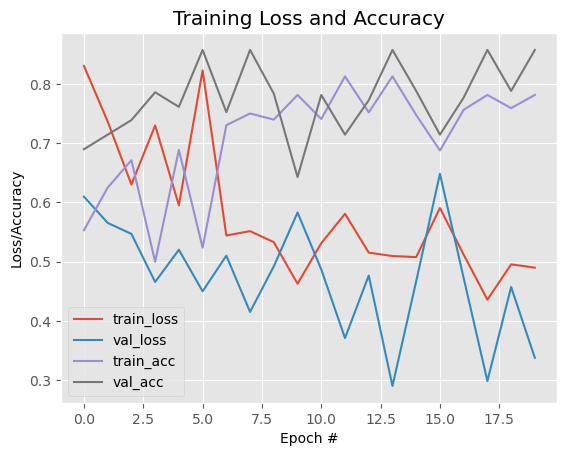

In [1]:
# Import necessary packages
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Initialize constants
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = r"D:\Face Recognition System\FACE\dataset_face"
CATEGORIES = ["man", "woman"]

# Load and preprocess images
print("[INFO] loading images...")
data = []
labels = []

imagePaths = list(paths.list_images(DIRECTORY))

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Perform one-hot encoding on the labels
print("[INFO] encoding labels...")
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels, num_classes=len(CATEGORIES))

# Split the data into training and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
    test_size=0.20, stratify=labels, random_state=42)

# Construct the image data generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

# Load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CATEGORIES), activation="softmax")(headModel)

# Place the head FC model on top of the base model (this will become the actual model)
model = Model(inputs=baseModel.input, outputs=headModel)

# Loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# Define learning rate decay
lr_schedule = ExponentialDecay(initial_learning_rate=INIT_LR, decay_steps=100000, decay_rate=0.96, staircase=True)
opt = Adam(learning_rate=lr_schedule)

# Compile the model
print("[INFO] compiling model...")
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# Train the head of the network
print("[INFO] training head...")

# Ensure validation data generator is set up correctly
valAug = ImageDataGenerator()

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=valAug.flow(testX, testY, batch_size=BS),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    shuffle=True
)

# Make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# For each image in the testing set, find the index of the label with the corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# Save the model
print("[INFO] saving face recognition model...")
model.save("face_recognition.h5")  # Save the model in HDF5 format

# Plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")
